In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
np.random.seed(69)
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns
sns.set()
# from tqdm.notebook 
import tqdm
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import time
import pickle
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from linformer import LinformerCA
from vit_pytorch.efficient_new import ViT


In [2]:
dnnx_sg = np.load("/home/srinadb/SG/SGP/Dataset/Experiment3/dnnx_sgq_exp3.npy")
X_sg = np.load("/home/srinadb/SG/SGP/Dataset/Experiment3/X_sgq_exp3.npy")
X_sg = X_sg.transpose((0, 3, 1, 2))

y_sg = np.load("/home/srinadb/SG/SGP/Dataset/Experiment3/y_sgq_exp3.npy")
y_sg = np.argmax(y_sg, axis=1)

In [3]:
def get_metrics(y_pred, y_test, labels, to_print=True):
    correct_labels = np.where(y_pred==y_test)[0]
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred,average='macro')
    recall = metrics.recall_score(y_test, y_pred,average='macro')
    f1score = metrics.f1_score(y_test, y_pred,average='macro')
    # rocscore = metrics.roc_auc_score(y_test, y_pred,average='micro',multi_class="ovo")
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)  
    classification_report = metrics.classification_report(y_test, y_pred)

    if to_print:
        print("Identified {} correct labels out of {} labels".format(len(correct_labels), y_test.shape[0]))
        print("Accuracy:",accuracy)
        print("Precision:",precision)
        print("Recall:",recall)
        print("F1 Score:",f1score)
        # print("ROC AUC Score:",rocscore)
        print(f"Labels are: {labels}")
        print("Confusion Matrix:\n", confusion_matrix)
        print("Classification_Report:\n", classification_report)

    return (correct_labels, accuracy, precision, recall, confusion_matrix, classification_report)

In [4]:
# Initialize the PyTorch model
n_classes = 3
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
in_channels = X_sg.shape[1]

PATCH_SIZE = 4
DEPTH = 12
HIDDEN_DIM = 64
K_DIM = 128
NUM_HEADS = 8

LR = 1e-3
STEP_SIZE = 5
GAMMA = 0.9

LIN_DROPOUT = 0.1

seq_len = int((32/PATCH_SIZE)**2) + 1 

## Linformer
lin = LinformerCA(dim=HIDDEN_DIM, seq_len=seq_len, depth=DEPTH, k=K_DIM, heads=NUM_HEADS,
                dim_head=None, one_kv_head=False, share_kv=False, reversible=False, dropout=LIN_DROPOUT)

## Vision Transformer
model = ViT(image_size=32, patch_size=PATCH_SIZE, num_classes=n_classes, dim=HIDDEN_DIM, transformer=lin, pool='cls', channels=in_channels).to(device)


cuda:0


In [5]:
# Load the saved model state dictionary
model.load_state_dict(torch.load('./Trained_Models/EX1_SGQ_ViTCLSPFParallelCA_Model.pth', map_location=device))

# Set the model to evaluation mode
model.eval()


ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=4, p2=4)
    (1): LayerNorm((80,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=80, out_features=64, bias=True)
    (3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (to_dnn): Sequential(
    (0): Linear(in_features=24, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.25, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.25, inplace=False)
    (9): Linear(in_features=256, out_features=64, bias=True)
  )
  (transformer): LinformerCA(
    (layers): ModuleList(
      (0-11): 12 x LinformerCABlock(
        (attn): PreNormCross(
          (fn): LinformerCrossAttention(
            (to_q): Linear(in_features=64, out_features=64, bias=False)
            (to_k)

In [6]:
class SGData(Dataset):
    def __init__(self, x1, x2, y, transform=None):
        self.n_samples = x2.shape[0]
        self.x1 = torch.tensor(x1, dtype=torch.float32)
        self.x2 = torch.tensor(x2, dtype=torch.float32)
        self.y = torch.tensor(y)
        self.transform = transform

    def __len__(self):
        return self.n_samples

    def __getitem__(self, i):
        inputs_pf, inputs_imgs, targets = self.x1[i], self.x2[i], self.y[i]
        
        if self.transform:
            inputs_pf = inputs_pf
            inputs_imgs = self.transform(inputs_imgs)

        return inputs_pf, inputs_imgs, targets

In [7]:
test_dataset = SGData(dnnx_sg, X_sg, y_sg, transform=None)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=4)


In [8]:
label_strings = ['GALAXY', 'QSO', 'STAR']
y_test_pred = torch.empty(0).to(device)
print('\n')
# Generate predictions
with torch.no_grad():
    for pf, images, labels in test_loader:
        pf = pf.to(device)
        images = images.to(device)
        labels = labels.to(device)
        pred = model(pf, images)

        y_test_pred = torch.cat((y_test_pred, pred), dim=0)

y_test_pred = y_test_pred.cpu().numpy()
y_test_pred = y_test_pred.argmax(axis=1)
print(get_metrics(y_test_pred, y_sg, label_strings))





Identified 21356 correct labels out of 28532 labels
Accuracy: 0.7484929202299173
Precision: 0.773269219112037
Recall: 0.7484884862042708
F1 Score: 0.7452507559562164
Labels are: ['GALAXY', 'QSO', 'STAR']
Confusion Matrix:
 [[9076  357   78]
 [3262 5915  333]
 [ 915 2231 6365]]
Classification_Report:
               precision    recall  f1-score   support

           0       0.68      0.95      0.80      9511
           1       0.70      0.62      0.66      9510
           2       0.94      0.67      0.78      9511

    accuracy                           0.75     28532
   macro avg       0.77      0.75      0.75     28532
weighted avg       0.77      0.75      0.75     28532

(array([    0,     1,     2, ..., 28524, 28525, 28526]), 0.7484929202299173, 0.773269219112037, 0.7484884862042708, array([[9076,  357,   78],
       [3262, 5915,  333],
       [ 915, 2231, 6365]]), '              precision    recall  f1-score   support\n\n           0       0.68      0.95      0.80      9511\n   

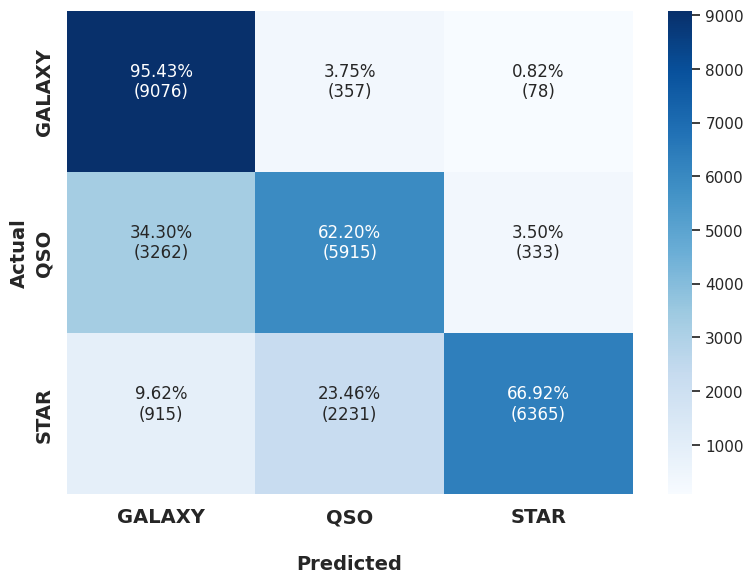

In [9]:
# https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/#google_vignette
# fig = plt.figure()
cf_matrix = metrics.confusion_matrix(y_sg, y_test_pred)
cf_matrix_percentage = metrics.confusion_matrix(y_sg, y_test_pred, normalize='true')
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix_percentage.flatten()]
labels = [f"{v1}\n({v2})\n" for v1, v2 in
          zip(group_percentages,group_counts)]
labels = np.asarray(labels).reshape(3,3)
fig, ax = plt.subplots(figsize=(8, 6))  # Adjust the size as needed

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_xlabel('\nPredicted', fontsize=14, weight='bold')
ax.set_ylabel('Actual', fontsize=14, weight='bold');
ax.xaxis.set_ticklabels(['GALAXY', 'QSO', 'STAR'], fontsize=14, weight='bold')
ax.yaxis.set_ticklabels(['GALAXY', 'QSO', 'STAR'], fontsize=14, weight='bold')
plt.tight_layout()
plt.savefig("Trained_Models/EX3_SGQ_ViTCLSPFParallelCA_CM.png")
# plt.close()
